# Let's introduce ourselves to python pandas and financial data

## First let's download some basic financial data

### Looking at the S&P500

In [ ]:
import yfinance as yf
import pandas as pd
import seaborn as sns 
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


sns.set_theme()

START_DATE = "2023-01-01"
END_DATE = "2025-01-01"

# Download daily price data for SPY
spy = yf.download("SPY", start=START_DATE, end=END_DATE, auto_adjust=True)

spy.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2023-01-03,367.150787,372.559407,364.268091,370.573351,74850700
2023-01-04,369.985291,372.029190,366.360243,369.426093,85934100
2023-01-05,365.762451,368.134143,365.164710,368.018455,76970500
2023-01-06,374.150146,375.278163,365.791366,368.876487,104189600
2023-01-09,373.938080,379.568484,373.754927,376.357995,73978100


In [58]:
new_columns = ['close', 'high', 'low', 'open', 'volume']

spy.columns = new_columns


spy.head()

,close,high,low,open,volume
Date,,,,,
2023-01-03,367.150787,372.559407,364.268091,370.573351,74850700
2023-01-04,369.985291,372.029190,366.360243,369.426093,85934100
2023-01-05,365.762451,368.134143,365.164710,368.018455,76970500
2023-01-06,374.150146,375.278163,365.791366,368.876487,104189600
2023-01-09,373.938080,379.568484,373.754927,376.357995,73978100


<Axes: xlabel='Date'>

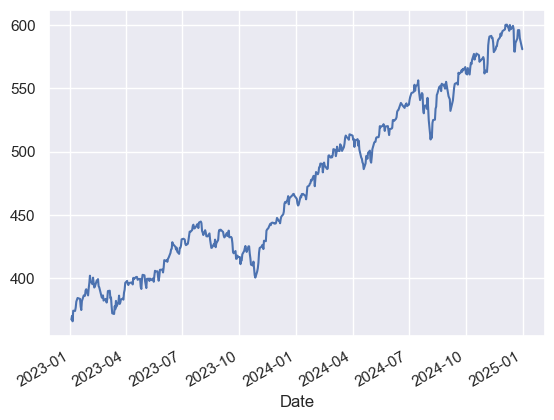

In [59]:
spy['close'].plot()

<Axes: ylabel='Frequency'>

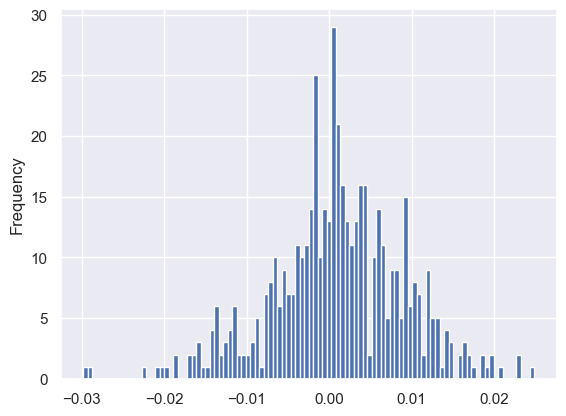

In [60]:
spy.loc[:, 'returns'] = spy['close'].pct_change()

spy['returns'].plot(kind='hist', bins=100)

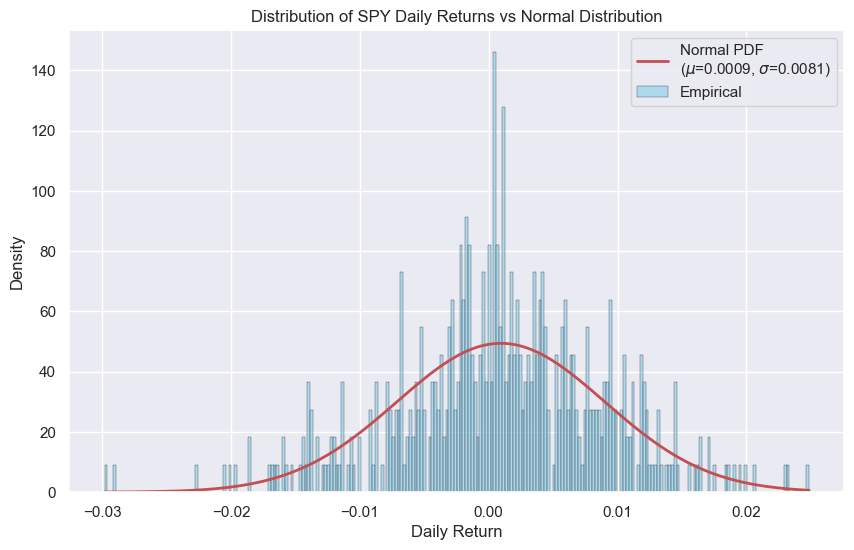

In [61]:
# Drop NA values from returns
returns_spy = spy["returns"].dropna()

# Estimate mean and std of returns
mu_spy, sigma_spy = returns_spy.mean(), returns_spy.std()

# Create a range of values for the normal PDF
x = np.linspace(returns_spy.min(), returns_spy.max(), 200)
pdf_spy = norm.pdf(x, mu_spy, sigma_spy)

# Plot histogram of returns with seaborn
plt.figure(figsize=(10, 6))
sns.histplot(returns_spy, bins=250, stat="density", color="skyblue", edgecolor="black", alpha=0.6, label="Empirical")

# Plot the normal PDF
plt.plot(x, pdf_spy, 'r-', lw=2, label=f"Normal PDF\n($\\mu$={mu_spy:.4f}, $\\sigma$={sigma_spy:.4f})")

plt.title("Distribution of SPY Daily Returns vs Normal Distribution")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.legend()
plt.show()


### Now let's compare it with NVDA

In [ ]:
nvd = yf.download("NVDA", start=START_DATE, end=END_DATE, auto_adjust=True)

new_columns = ['close', 'high', 'low', 'open', 'volume']

nvd.columns = new_columns

nvd.head()

[*********************100%***********************]  1 of 1 completed


,close,high,low,open,volume
Date,,,,,
2023-01-03,14.301480,14.981838,14.082687,14.836974,401277000
2023-01-04,14.735071,14.838973,14.227551,14.553244,431324000
2023-01-05,14.251526,14.550243,14.134636,14.477312,389168000
2023-01-06,14.844966,14.995823,14.020745,14.460329,405044000
2023-01-09,15.613241,16.040836,15.126701,15.269566,504231000


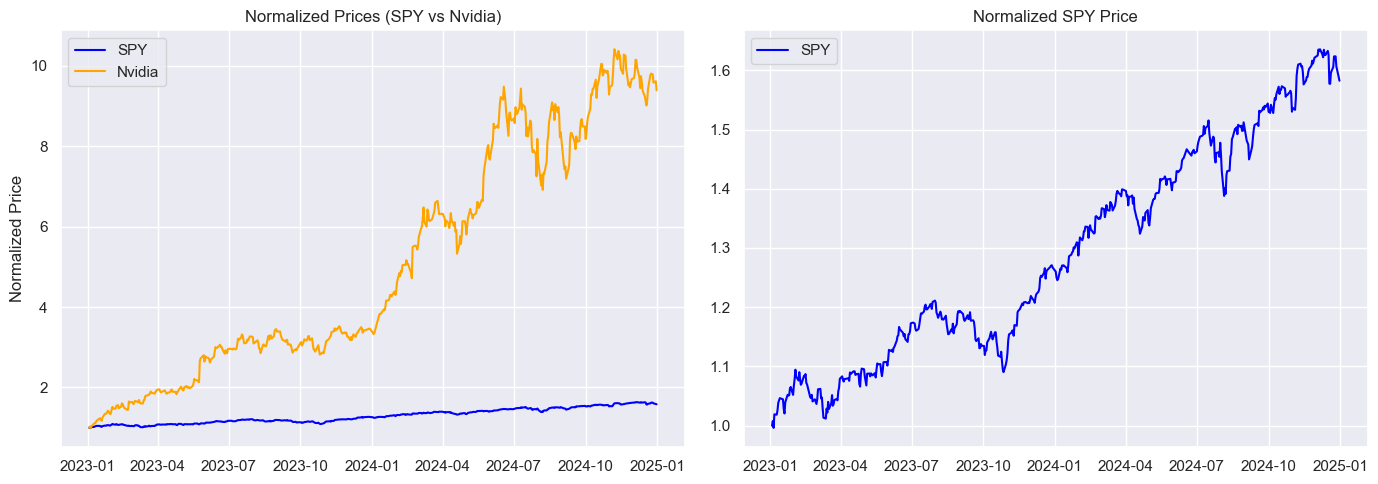

In [63]:
import matplotlib.pyplot as plt

# Normalize prices (start at 1)
spy_norm = spy["close"] / spy["close"].iloc[0]
nvd_norm = nvd["close"] / nvd["close"].iloc[0]

# Create 1 row, 2 column figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Left plot: SPY vs Nvidia normalized
axes[0].plot(spy.index, spy_norm, label="SPY", color="blue")
axes[0].plot(nvd.index, nvd_norm, label="Nvidia", color="orange")
axes[0].set_title("Normalized Prices (SPY vs Nvidia)")
axes[0].set_ylabel("Normalized Price")
axes[0].legend()

# Right plot: SPY only normalized
axes[1].plot(spy.index, spy_norm, label="SPY", color="blue")
axes[1].set_title("Normalized SPY Price")
axes[1].legend()

plt.tight_layout()
plt.show()


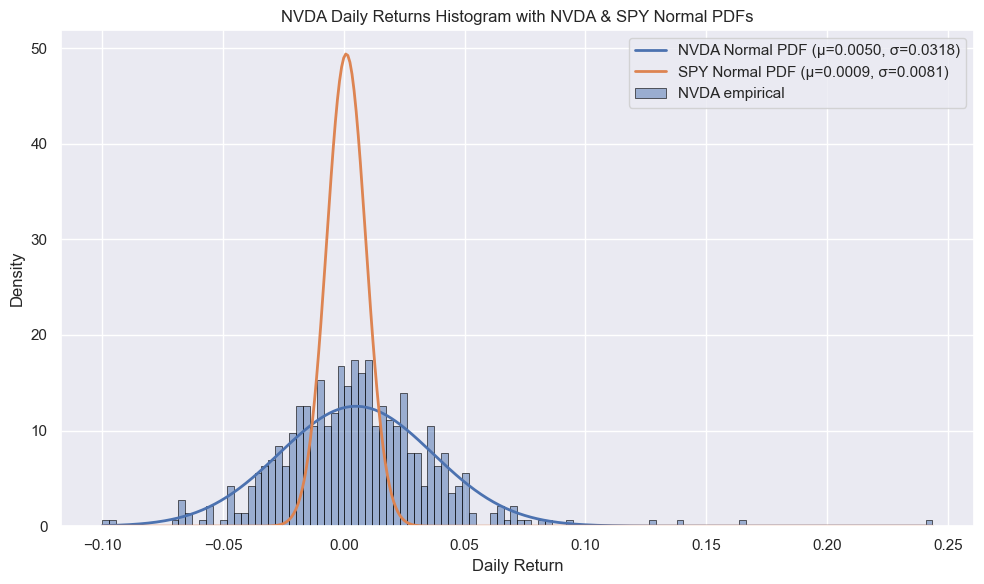

In [64]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# If your dataframes have 'Close' instead of 'close', change the keys accordingly.
# Compute returns
nvd["returns"] = nvd["close"].pct_change()
spy["returns"] = spy["close"].pct_change()

# Drop NA
nvda_ret = nvd["returns"].dropna()
spy_ret = spy["returns"].dropna()

# Sample mean/std
mu_nvda, sigma_nvda = nvda_ret.mean(), nvda_ret.std()
mu_spy,  sigma_spy  = spy_ret.mean(),  spy_ret.std()

# x-range covering BOTH series for a fair visual comparison
x_min = min(nvda_ret.min(), spy_ret.min())
x_max = max(nvda_ret.max(), spy_ret.max())
x = np.linspace(x_min, x_max, 400)

# Normal PDFs implied by sample moments
pdf_nvda = norm.pdf(x, mu_nvda, sigma_nvda)
pdf_spy  = norm.pdf(x, mu_spy,  sigma_spy)

# Plot
sns.set_theme()
plt.figure(figsize=(10, 6))

# Histogram of NVDA returns as density
sns.histplot(nvda_ret, bins=120, stat="density", edgecolor="black", alpha=0.5, label="NVDA empirical")

# Overlay PDFs
plt.plot(x, pdf_nvda, linewidth=2, label=f"NVDA Normal PDF (μ={mu_nvda:.4f}, σ={sigma_nvda:.4f})")
plt.plot(x, pdf_spy,  linewidth=2, label=f"SPY Normal PDF (μ={mu_spy:.4f}, σ={sigma_spy:.4f})")

plt.title("NVDA Daily Returns Histogram with NVDA & SPY Normal PDFs")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


## Now let's understand the "fat tails"

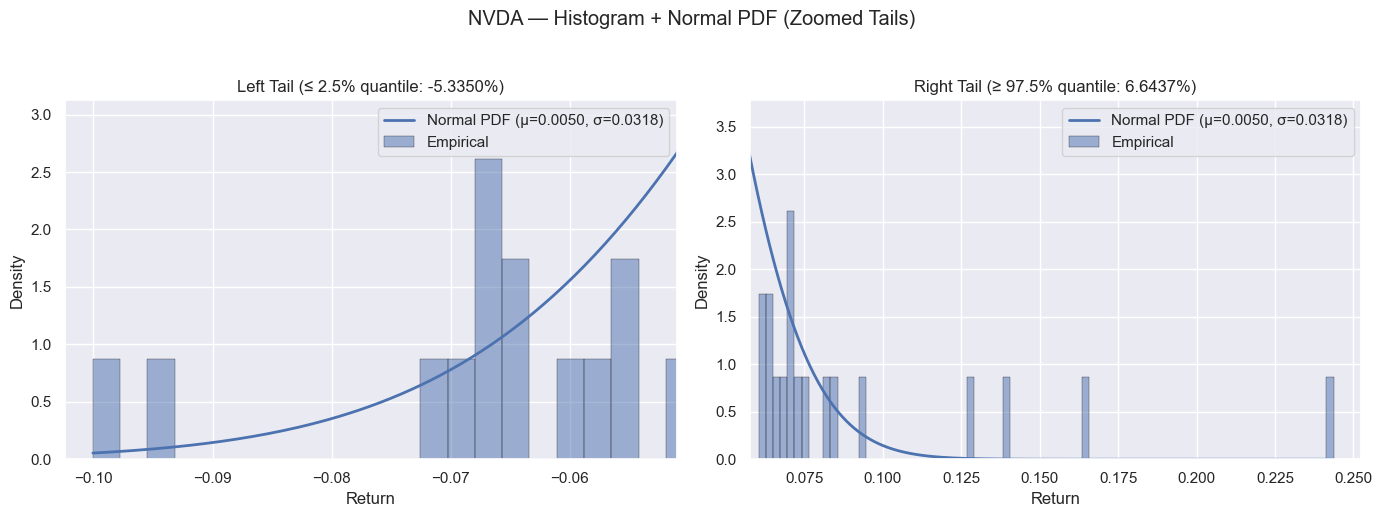

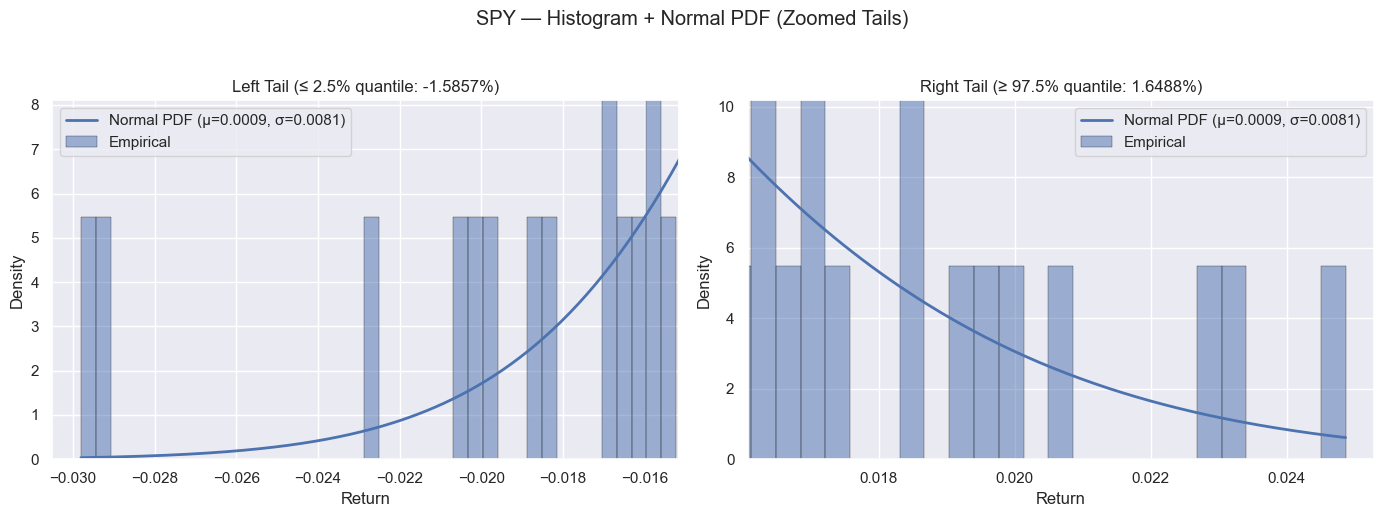

In [65]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.set_theme()

def _close_col(df):
    return "close" if "close" in df.columns else "Close"

def tail_zoom_hist_with_normal(df, label, tail_q=0.025, bins=120):
    # returns + moments
    r = df[_close_col(df)].pct_change().dropna()
    mu, sigma = r.mean(), r.std()

    # full-range x for the normal curve
    x = np.linspace(r.min(), r.max(), 800)
    pdf = norm.pdf(x, mu, sigma)

    # quantile cutoffs
    q_lo, q_hi = r.quantile(tail_q), r.quantile(1 - tail_q)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
    fig.suptitle(f"{label} — Histogram + Normal PDF (Zoomed Tails)", y=1.03)

    # --- Left tail zoom ---
    ax = axes[0]
    sns.histplot(r, bins=bins, stat="density", edgecolor="black", alpha=0.5, ax=ax, label="Empirical")
    ax.plot(x, pdf, linewidth=2, label=f"Normal PDF (μ={mu:.4f}, σ={sigma:.4f})")

    # zoom in on left tail
    margin = (q_lo - r.min()) * 0.05
    ax.set_xlim(r.min() - margin, q_lo + margin)

    # adjust ylim to max density in this region
    mask_left = (x >= r.min() - margin) & (x <= q_lo + margin)
    ymax_left = max(pdf[mask_left].max(), 1e-6) * 1.2
    ax.set_ylim(0, ymax_left)

    ax.set_title(f"Left Tail (≤ {tail_q:.1%} quantile: {q_lo:.4%})")
    ax.set_xlabel("Return")
    ax.set_ylabel("Density")
    ax.legend()

    # --- Right tail zoom ---
    ax = axes[1]
    sns.histplot(r, bins=bins, stat="density", edgecolor="black", alpha=0.5, ax=ax, label="Empirical")
    ax.plot(x, pdf, linewidth=2, label=f"Normal PDF (μ={mu:.4f}, σ={sigma:.4f})")

    # zoom in on right tail
    margin = (r.max() - q_hi) * 0.05
    ax.set_xlim(q_hi - margin, r.max() + margin)

    # adjust ylim to max density in this region
    mask_right = (x >= q_hi - margin) & (x <= r.max() + margin)
    ymax_right = max(pdf[mask_right].max(), 1e-6) * 1.2
    ax.set_ylim(0, ymax_right)

    ax.set_title(f"Right Tail (≥ {1 - tail_q:.1%} quantile: {q_hi:.4%})")
    ax.set_xlabel("Return")
    ax.set_ylabel("Density")
    ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
tail_zoom_hist_with_normal(nvd, "NVDA", tail_q=0.025, bins=150)
tail_zoom_hist_with_normal(spy, "SPY",  tail_q=0.025, bins=150)


## Now let's try to trade stupidly

In [66]:
spy.head()

,close,high,low,open,volume,returns
Date,,,,,,
2023-01-03,367.150787,372.559407,364.268091,370.573351,74850700,NaN
2023-01-04,369.985291,372.029190,366.360243,369.426093,85934100,0.007720
2023-01-05,365.762451,368.134143,365.164710,368.018455,76970500,-0.011414
2023-01-06,374.150146,375.278163,365.791366,368.876487,104189600,0.022932
2023-01-09,373.938080,379.568484,373.754927,376.357995,73978100,-0.000567


In [67]:
import pandas as pd

# Add a boolean column for Monday
spy["is_monday"] = (spy.index.weekday == 0).astype(int)

spy.head()


,close,high,low,open,volume,returns,is_monday
Date,,,,,,,
2023-01-03,367.150787,372.559407,364.268091,370.573351,74850700,NaN,0
2023-01-04,369.985291,372.029190,366.360243,369.426093,85934100,0.007720,0
2023-01-05,365.762451,368.134143,365.164710,368.018455,76970500,-0.011414,0
2023-01-06,374.150146,375.278163,365.791366,368.876487,104189600,0.022932,0
2023-01-09,373.938080,379.568484,373.754927,376.357995,73978100,-0.000567,1


<Axes: xlabel='Date'>

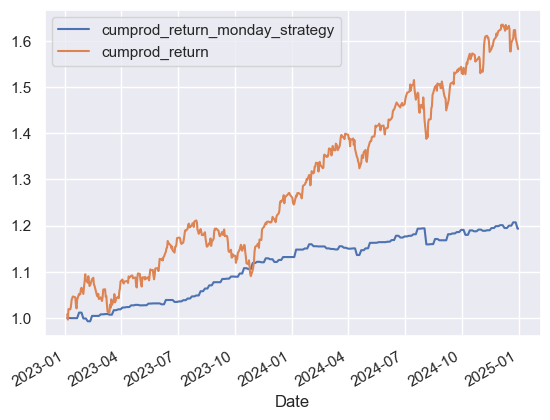

In [68]:
spy.loc[:, 'return_monday_strategy'] = spy['is_monday'] * spy['returns']

spy.loc[:, 'cumprod_return_monday_strategy'] = (1 + spy['return_monday_strategy']).cumprod()
spy.loc[:, 'cumprod_return'] = (1 + spy['returns']).cumprod()
spy.head()

spy['cumprod_return_monday_strategy'].plot(legend='monday strat')
spy['cumprod_return'].plot(legend='benchmark spy')



In [76]:
mu_monday = spy['return_monday_strategy'].mean()
std_monday = spy['return_monday_strategy'].std()

sr_monday = np.sqrt(252) * mu_monday / std_monday

print(f'The sr of monday is {sr_monday}')

The sr of monday is 2.0478899427634842


In [69]:
spy['signal_trend_following'] = np.where(spy['returns'] > 0, 1, -1)
spy['signal_trend_following'] = spy['signal_trend_following'].shift(1)

spy.head()

,close,high,low,open,volume,returns,is_monday,return_monday_strategy,cumprod_return_monday_strategy,cumprod_return,signal_trend_following
Date,,,,,,,,,,,
2023-01-03,367.150787,372.559407,364.268091,370.573351,74850700,NaN,0,NaN,NaN,NaN,NaN
2023-01-04,369.985291,372.029190,366.360243,369.426093,85934100,0.007720,0,0.000000,1.000000,1.007720,-1.0
2023-01-05,365.762451,368.134143,365.164710,368.018455,76970500,-0.011414,0,-0.000000,1.000000,0.996219,1.0
2023-01-06,374.150146,375.278163,365.791366,368.876487,104189600,0.022932,0,0.000000,1.000000,1.019064,-1.0
2023-01-09,373.938080,379.568484,373.754927,376.357995,73978100,-0.000567,1,-0.000567,0.999433,1.018486,1.0


<Axes: xlabel='Date'>

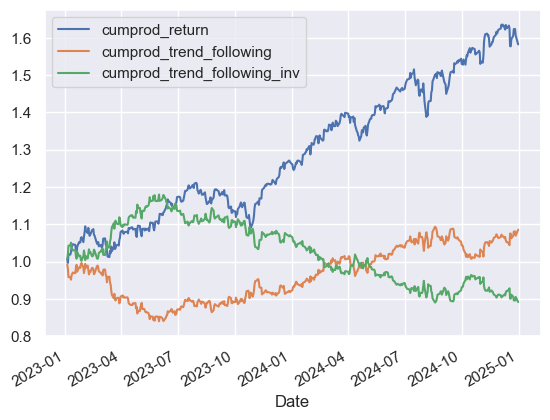

In [70]:
spy.loc[:, 'returns_trend_following'] = spy['returns'] * spy['signal_trend_following']
spy.loc[:, 'returns_trend_following_inv'] = spy['returns'] * spy['signal_trend_following'] * -1

spy.loc[:, 'cumprod_trend_following'] = (1 + spy['returns_trend_following']).cumprod()
spy.loc[:, 'cumprod_trend_following_inv'] = (1 + spy['returns_trend_following_inv']).cumprod()

spy['cumprod_return'].plot(legend=True)
spy['cumprod_trend_following'].plot(legend=True)
spy['cumprod_trend_following_inv'].plot(legend=True)

In [71]:
mu_spy = spy['returns'].mean()
std_spy = spy['returns'].std()
sr_spy = mu_spy/std_spy


mu_tf = spy['returns_trend_following'].mean()
std_tf = spy['returns_trend_following'].std()
sr_tf = mu_tf/std_tf

mu_tfi = spy['returns_trend_following_inv'].mean()
std_tfi = spy['returns_trend_following_inv'].std()
sr_tfi = mu_tfi/std_tfi

print(f'The sr of spy is {np.sqrt(252)*sr_spy}')
print(f'The sr of tf is {np.sqrt(252)*sr_tf}')
print(f'The sr of tfi is {np.sqrt(252)*sr_tfi}')

The sr of spy is 1.8657558674214878
The sr of tf is 0.38375747725107723
The sr of tfi is -0.38375747725107723


## Let's throw in the BTC as we all love cryptos

[*********************100%***********************]  1 of 1 completed

The sr of btc is 1.6686478348223484


<Axes: xlabel='Date'>

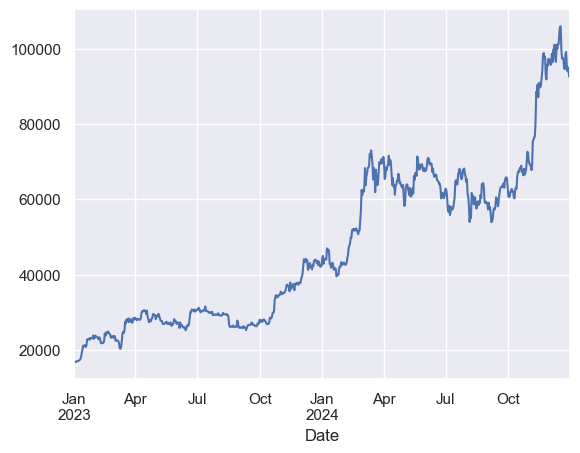

In [ ]:
btc = yf.download("BTC-USD", start=START_DATE, end=END_DATE, auto_adjust=True)

btc.columns = new_columns
btc.loc[:, 'returns'] = btc['close'].pct_change()

mu_btc = btc['returns'].mean()
std_btc = btc['returns'].std()
sr_btc = np.sqrt(252)*mu_btc / std_btc

print(f'The sr of btc is {sr_btc}')

btc['close'].plot()

## CHARAF TO DO

In [73]:
df_1 = yf.download("MCD", start="2015-01-01", end="2025-01-01", auto_adjust=True)
df_1.columns = new_columns
df_1 = df_1[['close', 'volume']]
df_1.loc[:, 'ret'] = df_1['close'].pct_change()
df_1.loc[:, 'cumprod'] = (1 +df_1['ret']).cumprod()

df_2 = yf.download('QSR', start="2015-01-01", end="2025-01-01", auto_adjust=True)
df_2.columns = new_columns
df_2 = df_2[['close', 'volume']]
df_2.loc[:, 'ret'] = df_2['close'].pct_change()
df_2.loc[:, 'cumprod'] = (1 +df_2['ret']).cumprod()

df = pd.merge(df_1, df_2, left_index=True, right_index=True, suffixes=['_MCD', '_QSR'])

df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,close_MCD,volume_MCD,ret_MCD,cumprod_MCD,close_QSR,volume_QSR,ret_QSR,cumprod_QSR
Date,,,,,,,,
2015-01-02,71.094536,6019700,NaN,NaN,28.264406,749800,NaN,NaN
2015-01-05,70.309349,6211900,-0.011044,0.988956,27.880850,1169600,-0.013570,0.986430
2015-01-06,70.438950,6484100,0.001843,0.990779,27.932478,1532500,0.001852,0.988256
2015-01-07,71.666298,6400300,0.017424,1.008042,29.009369,2298400,0.038553,1.026357
2015-01-08,71.933083,5476700,0.003723,1.011795,29.761700,1730100,0.025934,1.052975


In [74]:
# window = 150

# cov_prices = df['close_MCD'].rolling(window=window, min_periods=window).cov(df['close_QSR'])
# var_prices = df['close_QSR'].rolling(window=window, min_periods=window).var()

# df['rolling_beta_150_prices'] = cov_prices / var_prices

# df.dropna().head()

<Axes: xlabel='Date'>

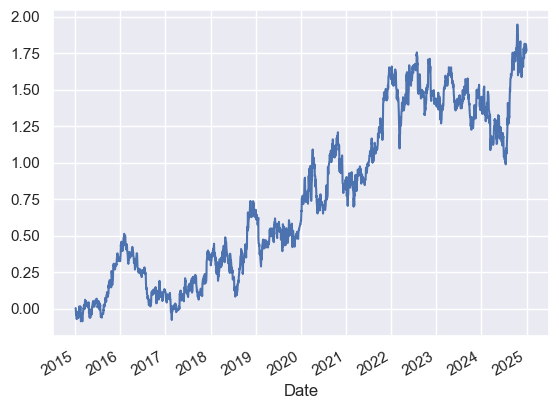

In [75]:
(df['cumprod_MCD'] - df['cumprod_QSR']).plot()